# Time to get your hands dirty! Supernova distances and redshifts (part 1)
Measuring the cosmological relationship between distance and redshift is at the heart of the entire field of cosmology and allowed, among other things, the discovery of dark energy! At high redshifts, this is done with Type Ia Supernova which are standard (or better, standardizable) candles.

This is a Nobel prize plot by Riess et al

Let's recall the definition of magnitude and the distance modulus (ah! the astronomers...)
$$
\mu = m - M = 5 \log_{10} \left( \frac{d_L}{\text{pc}} \right) - 5
$$

Here is the Hubble diagram for Type Ia supernovae (which are standard candels). The lines show the predictions for cosmologies with varying amounts of Ωm and ΩΛ. The observed points all lie above the line for a universe with zero Λ. The lower panel, with the slope caused by the inverse square law taken out, shows the difference between the predictions more clearly and shows why a model with ΩΛ > 0 is favored.

## Tasks
- First, explore fitting this data with the tecniques we have seen.
- Start from linear regression and polynomial regression
- For the case of polynomial regression, just fit many of them for now.
- Let's bet based on intuition! Which fit is the best?
- In what cases are you underfitting the data?
- In what cases are you overfitting the data?
- Now split the data into training and validation sets
- Implement a cross-validation procedure
- Pick the best!
- Does it agree with our bets?

## Optional
- Repeat with Basis Function Regression and Kernel Regression
- Explore what happens when you change the number of datapoints and plot the resulting learning curves.


In [1]:
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as sns
import pandas as pd
from astroML.linear_model import LinearRegression
from astroML.linear_model import PolynomialRegression
from sklearn.model_selection import train_test_split
from astroML.linear_model import BasisFunctionRegression
from astroML.linear_model import NadarayaWatson

/home/sara/myenv/lib/python3.10/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


(35.0, 50.0)

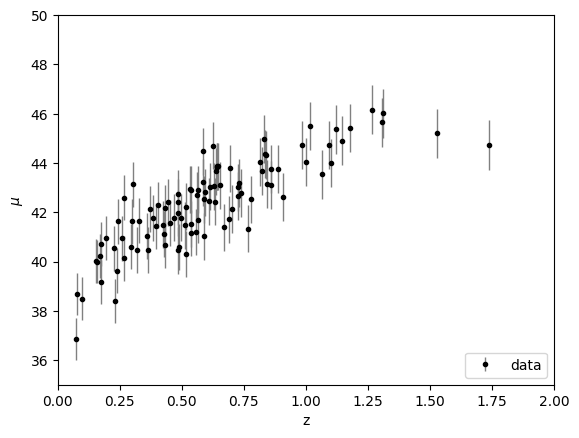

In [2]:
from astroML.datasets import generate_mu_z
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234) 

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

## Linear Regression

In [3]:
z_sample=z_sample.reshape(-1,1) # Reshape z_sample to a 2D array for sklearn

# Initialize and fit a linear regression model 
model = LinearRegression()
model.fit(z_sample, mu_sample, dmu) # Use dmu as weights to account for errors
print(model.coef_)

[39.48384602  4.76438865]


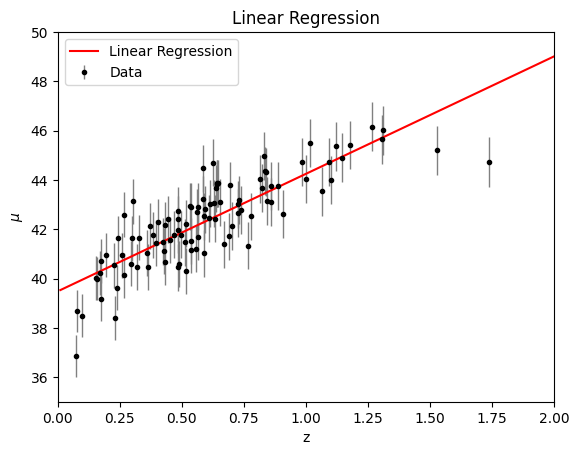

In [4]:
z_plot = np.linspace(0.01, 2, 1000).reshape(-1, 1)
mu_pred = model.predict(z_plot) # Predict mu values using the fitted model
# Plot original data with error bars and the linear regression fit
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='Data')
plt.plot(z_plot, mu_pred, color='red', label='Linear Regression')
plt.xlabel("z")
plt.ylabel(r"$\mu$")
plt.xlim(0, 2)
plt.ylim(35, 50)
plt.legend()
plt.title("Linear Regression")
plt.show()

## Polynomial Regression

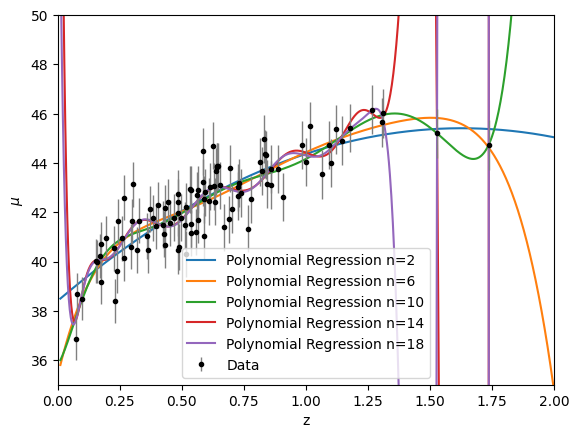

In [6]:
z_sample = z_sample.reshape(-1, 1)
z_plot = np.linspace(0.01, 2, 1000).reshape(-1, 1)
n= np.arange(1, 20)
# Loop over polynomial degrees, fit model, and plot predictions
for i in n[1::4]:
    model = PolynomialRegression(i)
    model.fit(z_sample, mu_sample, dmu)

    mu_pred = model.predict(z_plot) 

    plt.plot(z_plot, mu_pred, label='Polynomial Regression n='+str(i))

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='Data')
plt.xlabel('z')
plt.ylabel(r'$\mu$')
plt.xlim(0, 2)
plt.ylim(35, 50)
plt.legend()
plt.show()


## Basis Function Regression

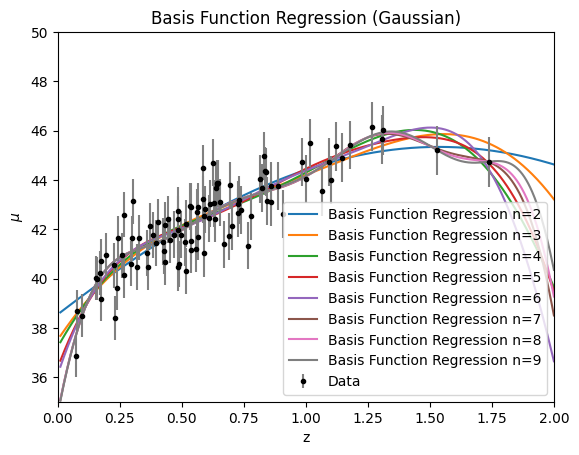

In [7]:
z_plot = np.linspace(0.01, 2, 1000).reshape(-1, 1)
n = np.arange(2,10) # Range of numbers of basis functions to test
# Fit and plot Basis Function Regression models with varying numbers of Gaussian bases
for i in n:
    mu = np.linspace(0, 2, i)[:, None] # Define centers (mu) of Gaussian basis functions evenly spaced in [0,2]
    sigma = 1.0 * (mu[1] - mu[0]) # Set width (sigma) based on spacing between centers

    modelBFR = BasisFunctionRegression('gaussian', mu=mu, sigma=sigma) # Initialize Basis Function Regression with Gaussian kernels
    modelBFR.fit(z_sample, mu_sample, dmu)
    mu_pred = modelBFR.predict(z_plot)

    plt.plot(z_plot, mu_pred,label='Basis Function Regression n='+str(i))

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', label='Data')
plt.xlabel('z')
plt.ylabel(r'$\mu$')
plt.xlim(0, 2)
plt.ylim(35, 50)
plt.title('Basis Function Regression (Gaussian)')
plt.legend()
plt.show()

## Kernel regression

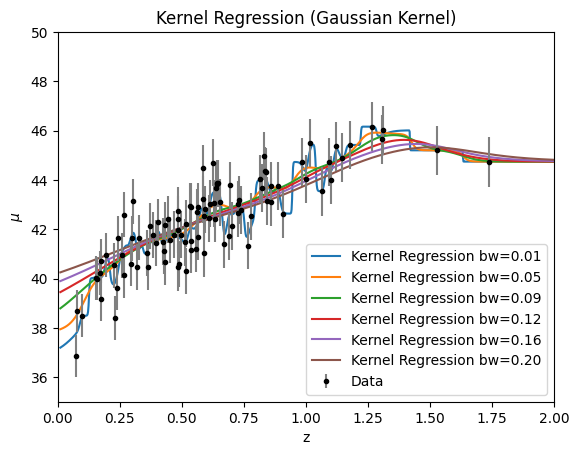

In [10]:
h=np.linspace(0.01,0.2,6)
z_plot = np.linspace(0.01, 2, 1000).reshape(-1, 1)
#Loop over different bandwidth (h) values for Gaussian Kernel Regression and for each bandwidth, fit the model and plot the predicted curve
for i in h:
    modelK = NadarayaWatson(kernel='gaussian',h=i)
    modelK.fit(z_sample, mu_sample)

    mu_pred = modelK.predict(z_plot)
    plt.plot(z_plot, mu_pred, label=f'Kernel Regression bw={i:.2f}')


plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', label='Data')
plt.xlabel('z')
plt.ylabel(r'$\mu$')
plt.title('Kernel Regression (Gaussian Kernel)')
plt.legend()
plt.xlim(0, 2)
plt.ylim(35, 50)
plt.show()

## Cross-Validation

In [11]:
z_train, z_val, mu_train, mu_val, dmu_train, dmu_val = train_test_split(z_sample, mu_sample, dmu, test_size=0.3, random_state=42) # Split data into training (70%) and validation (30%) sets

In [12]:
# Define RMSE error function
def error(pred, true):
    return np.sqrt(np.mean((true - pred)**2)) 

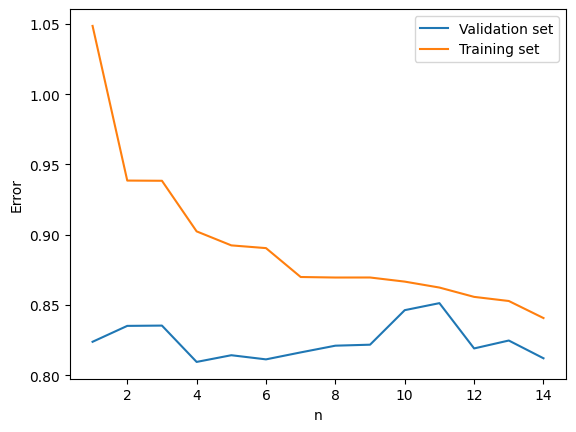

In [13]:
z_train = z_train.reshape(-1, 1)
z_val = z_val.reshape(-1, 1)
n=np.arange(1,15) # Range of polynomial degrees to test
error_train=[]
error_validation=[]
# Loop over polynomial degrees, fit model and compute errors on train and validation sets
for i in n:
    modelP = PolynomialRegression(i)
    modelP.fit(z_train, mu_train,dmu_train)

    mu_predtrain=modelP.predict(z_train) 
    mu_predval = modelP.predict(z_val) 

    et= error(mu_predtrain,mu_train) # Training error (RMSE)
    ev= error(mu_predval,mu_val)  # Validation error (RMSE)
    error_train.append(et)
    error_validation.append(ev)

# Plot training and validation errors vs polynomial degree
plt.plot(np.arange(1,15),error_validation, label='Validation set')
plt.plot(np.arange(1,15),error_train, label='Training set')

plt.xlabel('n')
plt.ylabel('Error')
plt.legend()
plt.show()


In [14]:
# Find the polynomial degree with the lowest validation error
best_index = np.argmin(error_validation)
best_degree = n[best_index]
best_error = error_validation[best_index]
print(f"Best degree: {best_degree} with validation error = {best_error:.4f}")

Best degree: 4 with validation error = 0.8096


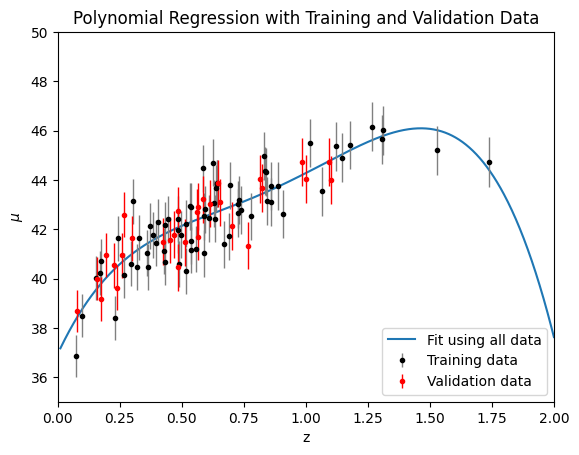

In [29]:
# Fit a polynomial regression model of degree 4 to all the data
z_sample = z_sample.reshape(-1, 1)
z_plot = np.linspace(0.01, 2, 1000).reshape(-1, 1)
model = PolynomialRegression(4)

model.fit(z_sample, mu_sample,dmu) 
mu_fit = model.predict(z_plot)

plt.plot(z_plot, mu_fit, label='Fit using all data')

plt.errorbar(z_train, mu_train, dmu_train, fmt='.k', ecolor='gray', lw=1,label='Training data')
plt.errorbar(z_val, mu_val, dmu_val, fmt='.r', ecolor='red', lw=1, label='Validation data')

plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.legend(loc='lower right')
plt.title("Polynomial Regression with Training and Validation Data")
plt.show()

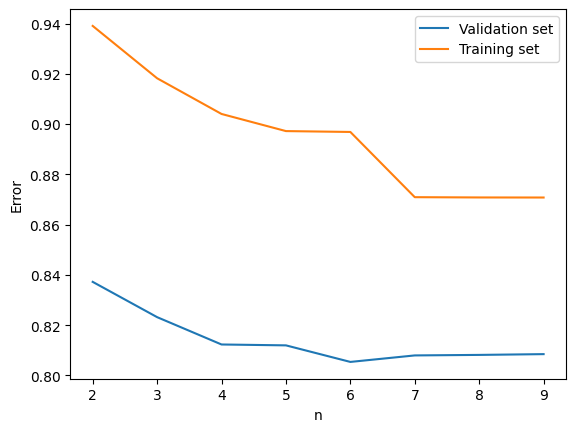

In [22]:
z_train = z_train.reshape(-1, 1)
z_val = z_val.reshape(-1, 1)
n = np.arange(2,10) # Range of number of Gaussian basis functions to test
error_train=[]
error_validation=[]
# Loop over number of basis functions, fit model, and calculate errors
for i in n:
    mu = np.linspace(0, 2, i)[:, None]
    sigma = 1.0 * (mu[1] - mu[0])

    modelBFR = BasisFunctionRegression('gaussian', mu=mu, sigma=sigma)
    modelBFR.fit(z_train, mu_train,dmu_train)

    mu_predtrain=modelBFR.predict(z_train) 
    mu_predval = modelBFR.predict(z_val) 

    et= error(mu_predtrain,mu_train)
    ev= error(mu_predval,mu_val)
    error_train.append(et)
    error_validation.append(ev)

# Plot training and validation errors vs number of basis functions
plt.plot(np.arange(2,10),error_validation, label='Validation set')
plt.plot(np.arange(2,10),error_train, label='Training set')

plt.xlabel('n')
plt.ylabel('Error')
plt.legend()
plt.show()

In [23]:
# Identify the model with the lowest validation error
best_index = np.argmin(error_validation)
best_degree = n[best_index]
best_error = error_validation[best_index]
print(f"Best degree: {best_degree} with validation error = {best_error:.4f}")

Best degree: 6 with validation error = 0.8054


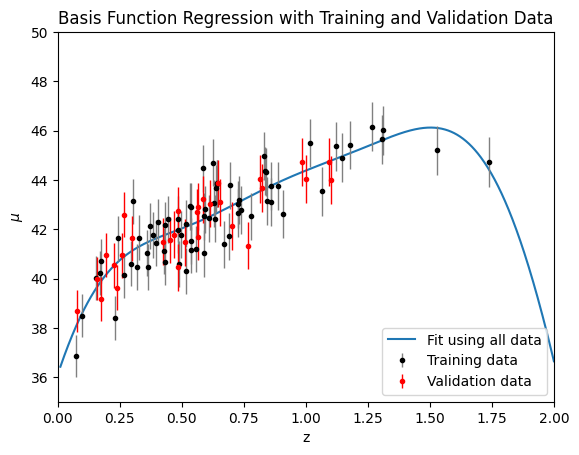

In [31]:
# Fit a Basis Function Regression model with 6 Gaussian bases to the training data 
z_sample = z_sample.reshape(-1, 1)
z_plot = np.linspace(0.01, 2, 1000).reshape(-1, 1)

mu = np.linspace(0, 2, 6)[:, None]
sigma = 1.0 * (mu[1] - mu[0])

modelBFR = BasisFunctionRegression('gaussian', mu=mu, sigma=sigma)
modelBFR.fit(z_sample, mu_sample,dmu)
mu_pred=modelBFR.predict(z_plot)

plt.plot(z_plot, mu_pred, label='Fit using all data')

plt.errorbar(z_train, mu_train, dmu_train, fmt='.k', ecolor='gray', lw=1,label='Training data')
plt.errorbar(z_val, mu_val, dmu_val, fmt='.r', ecolor='red', lw=1, label='Validation data')

plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.legend(loc='lower right')
plt.title("Basis Function Regression with Training and Validation Data")
plt.show()

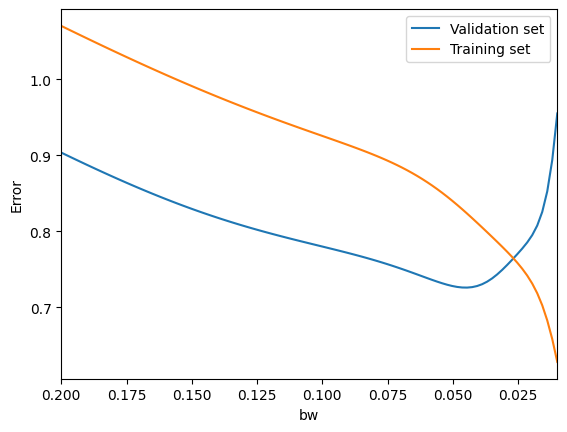

In [24]:
z_train = z_train.reshape(-1, 1)
z_val = z_val.reshape(-1, 1)
h=np.linspace(0.01,0.2,100) # Define range of bandwidth (bw) values to test for Kernel Regression
error_train=[]
error_validation=[]

# Loop over bandwidths, fit Kernel Regression and compute errors on train and validation sets
for i in h:
    modelK = NadarayaWatson('gaussian', i)
    modelK.fit(z_train, mu_train)

    mu_predtrain=modelK.predict(z_train) 
    mu_predval = modelK.predict(z_val) 

    et= error(mu_predtrain,mu_train)
    ev= error(mu_predval,mu_val)
    error_train.append(et)
    error_validation.append(ev)

# Plot training and validation errors versus bandwidth values
plt.plot(h,error_validation, label='Validation set')
plt.plot(h,error_train, label='Training set')
plt.xlim(h[-1],h[0]) # Flip x-axis: smaller (complex) bandwidths on right, larger (smooth) on left
plt.xlabel('bw')
plt.ylabel('Error')
plt.legend()
plt.show()

In [26]:
# Find and print the bandwidth that gives the lowest validation error
best_index = np.argmin(error_validation)
best_bw = h[best_index]
best_error = error_validation[best_index]
print(f"Best bandwidth: {best_bw:.4f} with validation error = {best_error:.4f}")

Best bandwidth: 0.0445 with validation error = 0.7259


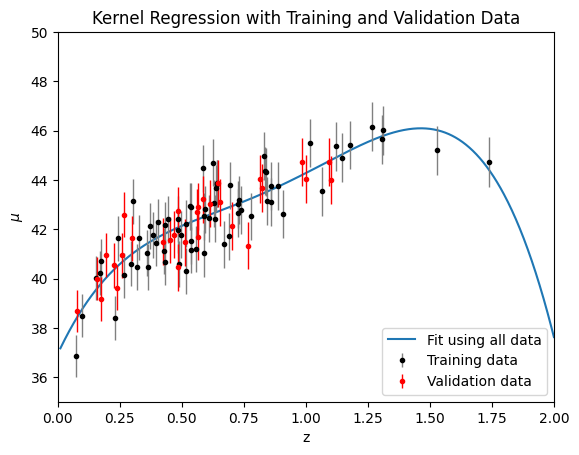

In [33]:
# Fit a Nadaraya-Watson Kernel Regression model with Gaussian kernel bandwidth 0.0445
z_sample = z_sample.reshape(-1, 1)
z_plot = np.linspace(0.01, 2, 1000).reshape(-1, 1)
modelK = NadarayaWatson(kernel='gaussian',h=0.0445)

modelK.fit(z_sample, mu_sample)
mu_pred = modelK.predict(z_plot)
   
plt.plot(z_plot, mu_fit, label='Fit using all data')

plt.errorbar(z_train, mu_train, dmu_train, fmt='.k', ecolor='gray', lw=1,label='Training data')
plt.errorbar(z_val, mu_val, dmu_val, fmt='.r', ecolor='red', lw=1, label='Validation data')

plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.legend(loc='lower right')
plt.title("Kernel Regression with Training and Validation Data")
plt.show()
